In [3]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras import regularizers
import matplotlib.pyplot as plt

In [24]:
X_test = np.load("Data/X_test.npy")
y_test = np.load("Data/y_test.npy")
person_train_valid = np.load("Data/person_train_valid.npy")
X_train_valid = np.load("Data/X_train_valid.npy")
y_train_valid = np.load("Data/y_train_valid.npy")
person_test = np.load("Data/person_test.npy")

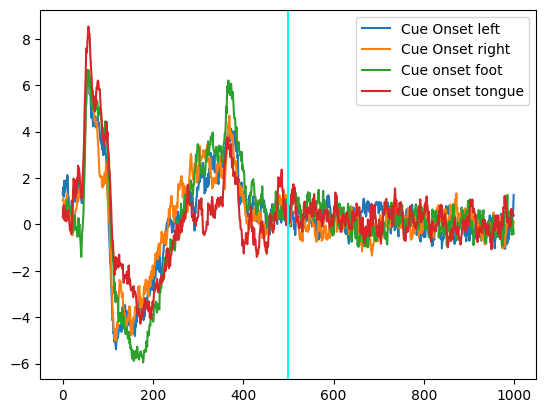

In [25]:
y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [6]:
def train_data_prep(X,y,sub_sample,average,noise):

    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    # Subsampling

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))


    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):

    total_X = None


    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)


    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X

In [26]:
## Preprocessing the dataset

X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep = test_data_prep(X_test)

## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1000, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid]
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of X after trimming: (2115, 22, 800)
Shape of X after maxpooling: (2115, 22, 400)
Shape of X after averaging+noise and concatenating: (4230, 22, 400)
Shape of X after subsampling and concatenating: (8460, 22, 400)
Shape of Y: (8460,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of training set: (7460, 22, 400)
Shape of validation set: (1000, 22, 400)
Shape of training labels: (7460,)
Shape of validation labels: (1000,)
Shape of training labels after categorical conversion: (7460, 4)
Shape of validation labels after categorical conversion: (1000, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (7460, 22, 400, 1)
Shape of validation set after adding width info: (1000, 22, 400, 1)
Shape of test set after adding width info: (443, 22, 400, 1)
Shape of training set after dimension reshaping: (7460, 400, 1, 22)
Shape of validation set after dimension reshaping: (1000, 400, 1, 22)

In [8]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_valid = x_valid.reshape(x_valid.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

In [9]:
X = np.concatenate((x_train, x_valid, x_test))
print("Shape of combined set:", X.shape)

Shape of combined set: (8903, 8800)


In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 566)
X_red = pca.fit_transform(X)
X_red.shape

(8903, 566)

In [11]:
X_red_train = X_red[0:7460]
X_red_valid = X_red[7460:8460]
X_red_test = X_red[8460:]

print('Shape of training set:',X_red_train.shape)
print('Shape of validation set:',X_red_valid.shape)
print('Shape of test set:',X_red_test.shape)

Shape of training set: (7460, 566)
Shape of validation set: (1000, 566)
Shape of test set: (443, 566)


In [19]:
fc_model2 = Sequential()

fc_model2.add(Dense(100, kernel_regularizer=regularizers.L2(1e-3), activation = "relu", input_dim = 566))
fc_model2.add(BatchNormalization())
fc_model2.add(Dropout(0.3))

fc_model2.add(Dense(40, kernel_regularizer=regularizers.L2(1e-3), activation = "relu"))
fc_model2.add(BatchNormalization())
fc_model2.add(Dropout(0.3))

fc_model2.add(Dense(10, kernel_regularizer=regularizers.L2(1e-3), activation = "relu"))
fc_model2.add(BatchNormalization())
fc_model2.add(Dropout(0.3))

fc_model2.add(Dense(4, kernel_regularizer=regularizers.L2(1e-3), activation='softmax'))

fc_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               56700     
                                                                 
 batch_normalization_3 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 40)                4040      
                                                                 
 batch_normalization_4 (Bat  (None, 40)                160       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 40)               

In [20]:
learning_rate = 1e-3
epochs = 125
fc_optimizer = keras.optimizers.Adam(learning_rate = learning_rate)

In [21]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=8)

# Compiling the model
fc_model2.compile(loss='categorical_crossentropy',
                 optimizer=fc_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
fc_model_results2 = fc_model2.fit(X_red_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             callbacks=[callback],
             validation_data=(X_red_valid, y_valid), verbose=True)

Epoch 1/125
117/117 [==============================] - 4s 8ms/step - loss: 1.9780 - accuracy: 0.2899 - val_loss: 1.4992 - val_accuracy: 0.4440
Epoch 2/125
117/117 [==============================] - 1s 5ms/step - loss: 1.6076 - accuracy: 0.3804 - val_loss: 1.3604 - val_accuracy: 0.5320
Epoch 3/125
117/117 [==============================] - 1s 5ms/step - loss: 1.4366 - accuracy: 0.4597 - val_loss: 1.2695 - val_accuracy: 0.6100
Epoch 4/125
117/117 [==============================] - 1s 5ms/step - loss: 1.3268 - accuracy: 0.5155 - val_loss: 1.1742 - val_accuracy: 0.6600
Epoch 5/125
117/117 [==============================] - 1s 5ms/step - loss: 1.2172 - accuracy: 0.5804 - val_loss: 1.0544 - val_accuracy: 0.7050
Epoch 6/125
117/117 [==============================] - 1s 5ms/step - loss: 1.1086 - accuracy: 0.6410 - val_loss: 0.9319 - val_accuracy: 0.7670
Epoch 7/125
117/117 [==============================] - 1s 5ms/step - loss: 0.9751 - accuracy: 0.7075 - val_loss: 0.8080 - val_accuracy: 0.7990

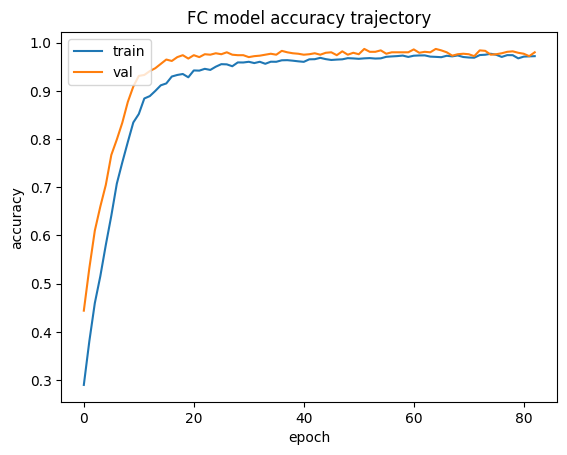

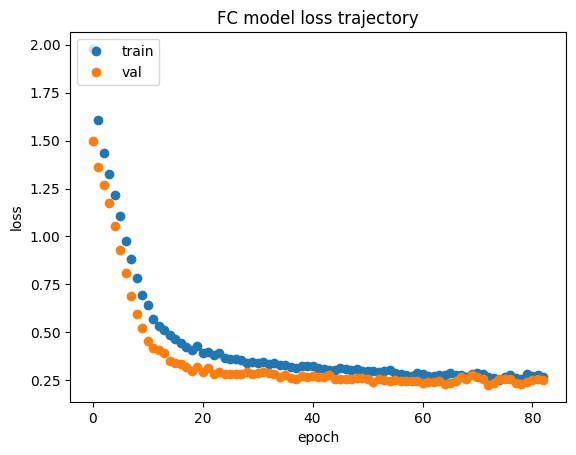

In [22]:
# Plotting accuracy trajectory
plt.plot(fc_model_results2.history['accuracy'])
plt.plot(fc_model_results2.history['val_accuracy'])
plt.title('FC model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(fc_model_results2.history['loss'],'o')
plt.plot(fc_model_results2.history['val_loss'],'o')
plt.title('FC model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
fc_score2 = fc_model2.evaluate(X_red_test, y_test, verbose=0)
print('Test accuracy of the FC model:',fc_score2[1])

Test accuracy of the FC model: 0.45146727561950684


In [28]:
p1_mask = (person_test == 1).flatten()
x_test = X_red_test[p1_mask]
y_test = y_test[p1_mask]

In [29]:
fc_score2 = fc_model2.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid FC model, single person:',fc_score2[1])

Test accuracy of the hybrid FC model, single person: 0.41999998688697815
